In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore")

In [2]:
# Load & Prepare Data
df = pd.read_csv("updated_QQQ_MarketRisk.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

In [3]:
# XGBoost Analysis (Rolling Fixed-Window)
mr = df[(df.Date.dt.year >= 2015) & (df.Date.dt.year <= 2023)].copy()
mr["NextVol"] = mr["QQQ_Realized_Volatility"].shift(-1)
features = [
    "QQQ_Return",
    "QQQ_Realized_Volatility",
    "QQQ_Volume",
    "VIX",
    "RSI_14",
    "VXN",
    "FedRate",
]
mr.dropna(subset=features + ["NextVol"], inplace=True)

results = []
first_date = mr.Date.min()
for _, row in mr.iterrows():
    today = row.Date
    if not (2020 <= today.year <= 2023):
        continue
    if today < first_date + pd.DateOffset(years=3):
        continue
    window_start = today - pd.DateOffset(years=3)
    train_df = mr[(mr.Date >= window_start) & (mr.Date < today)]
    if len(train_df) < 200:
        continue
    X_train, y_train = train_df[features], train_df["NextVol"]
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=50,
        learning_rate=0.05,
        random_state=42,
    )
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(row[features].values.reshape(1, -1))[0]
    results.append((today, y_pred, row.NextVol))

out_df = pd.DataFrame(results, columns=["Date", "PredictedNextVol", "ActualNextVol"])

In [4]:
# Compute XGBoost metrics manually
mse_xgb = mean_squared_error(out_df.ActualNextVol, out_df.PredictedNextVol)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(out_df.ActualNextVol, out_df.PredictedNextVol)
mae_xgb = mean_absolute_error(out_df.ActualNextVol, out_df.PredictedNextVol)
mape_xgb = mean_absolute_percentage_error(out_df.ActualNextVol, out_df.PredictedNextVol)

metrics_xgb = {
    "MSE": mse_xgb,
    "RMSE": rmse_xgb,
    "R2": r2_xgb,
    "MAE": mae_xgb,
    "MAPE": mape_xgb,
}
metrics_xgb

{'MSE': 0.0007780010924207633,
 'RMSE': 0.027892670944546765,
 'R2': 0.9521325329410291,
 'MAE': 0.014613066712283296,
 'MAPE': 0.05907844522347494}

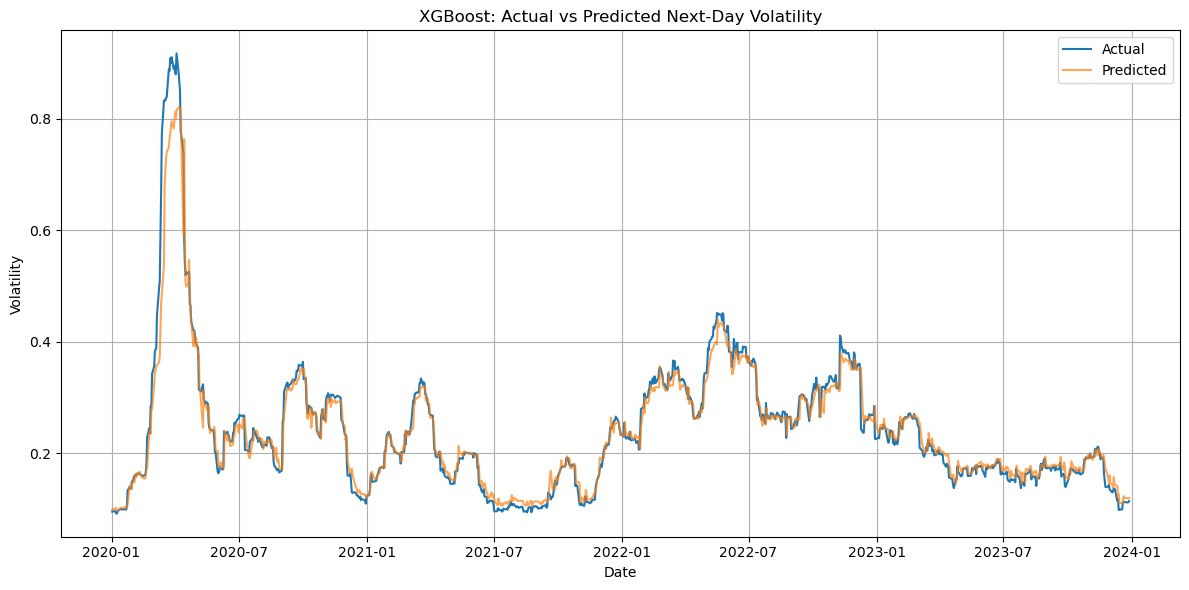

In [5]:
# Actual vs Predicted next-day volatility - line graph with grid
plt.figure(figsize=(12, 6))
plt.plot(out_df.Date, out_df.ActualNextVol, label="Actual")
plt.plot(out_df.Date, out_df.PredictedNextVol, label="Predicted", alpha=0.7)
plt.title("XGBoost: Actual vs Predicted Next-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)      
plt.tight_layout()
plt.show()

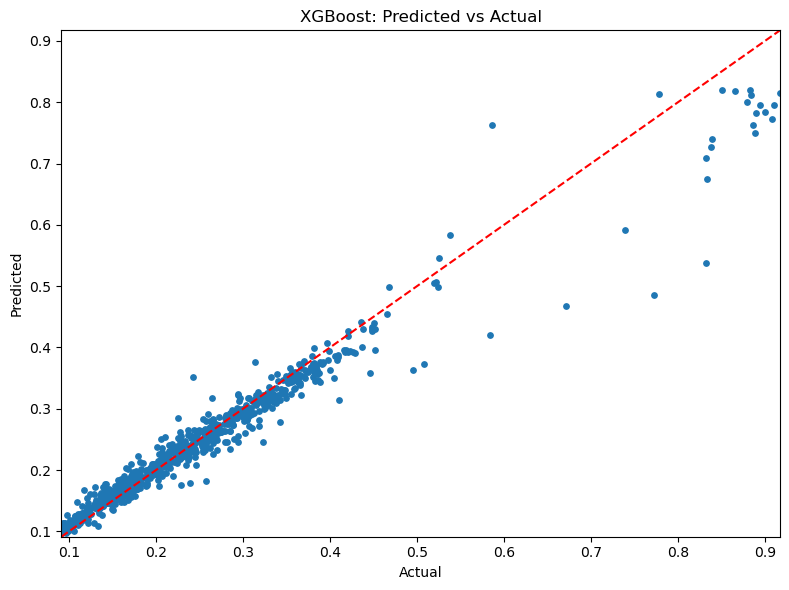

In [6]:
# Actual vs Predicted next-day volatility - scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(out_df.ActualNextVol, out_df.PredictedNextVol, s=15)
minv, maxv = (
    out_df[["ActualNextVol", "PredictedNextVol"]].min().min(),
    out_df[["ActualNextVol", "PredictedNextVol"]].max().max(),
)
plt.plot([minv, maxv], [minv, maxv], "r--")
plt.xlim(minv, maxv)
plt.ylim(minv, maxv)
plt.title("XGBoost: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

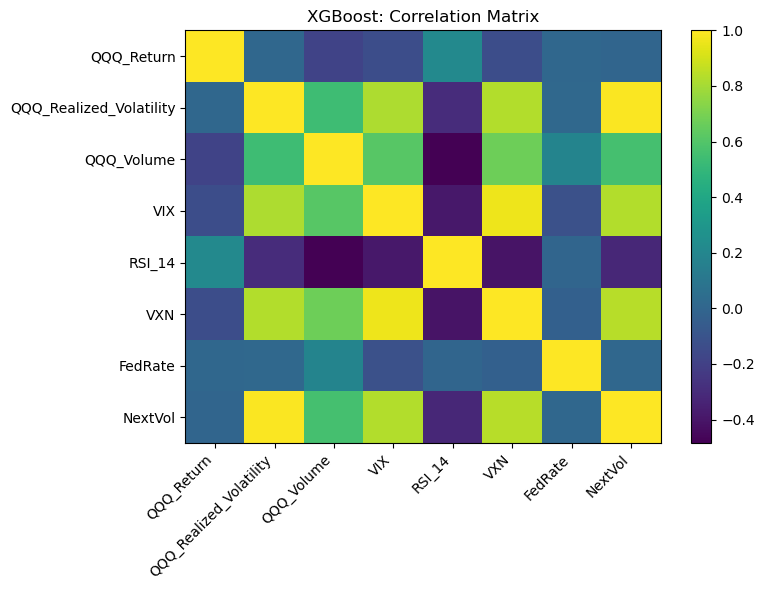

In [7]:
# Correlation matrix
corr = mr[features + ["NextVol"]].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.index)
plt.title("XGBoost: Correlation Matrix")
plt.tight_layout()
plt.show()

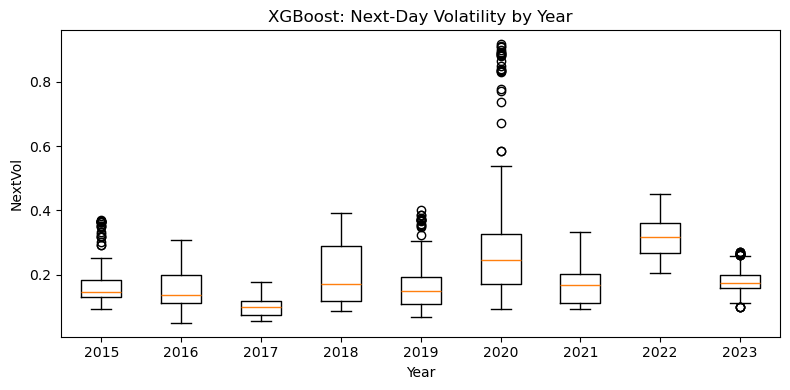

In [8]:
# Next-day volatility by year - Box plots
mr["Year"] = mr.Date.dt.year
years = sorted(mr.Year.unique())
data = [mr[mr.Year == y]["NextVol"].values for y in years]
plt.figure(figsize=(8, 4))
plt.boxplot(data)
plt.xticks(range(1, len(years) + 1), years)
plt.title("XGBoost: Next-Day Volatility by Year")
plt.xlabel("Year")
plt.ylabel("NextVol")
plt.tight_layout()
plt.show()

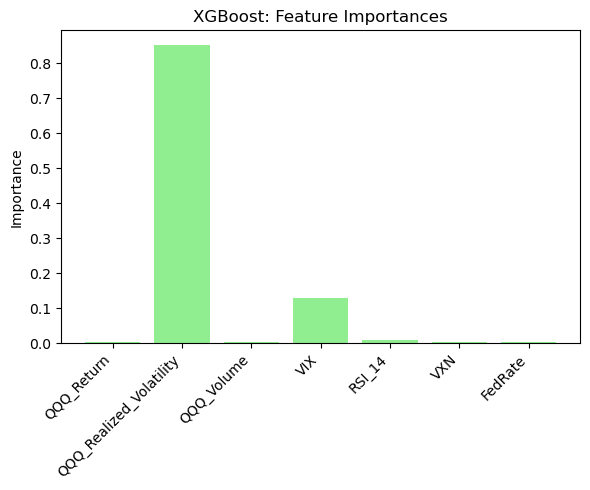

In [9]:
# Feature Importances - Bar chart
model_full = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=50,
    learning_rate=0.05,
    random_state=42,
)
model_full.fit(mr[features], mr["NextVol"], verbose=False)
importances = model_full.feature_importances_
plt.figure(figsize=(6, 5))
plt.bar(features, importances, color="lightgreen")
plt.xticks(rotation=45, ha="right")
plt.title("XGBoost: Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

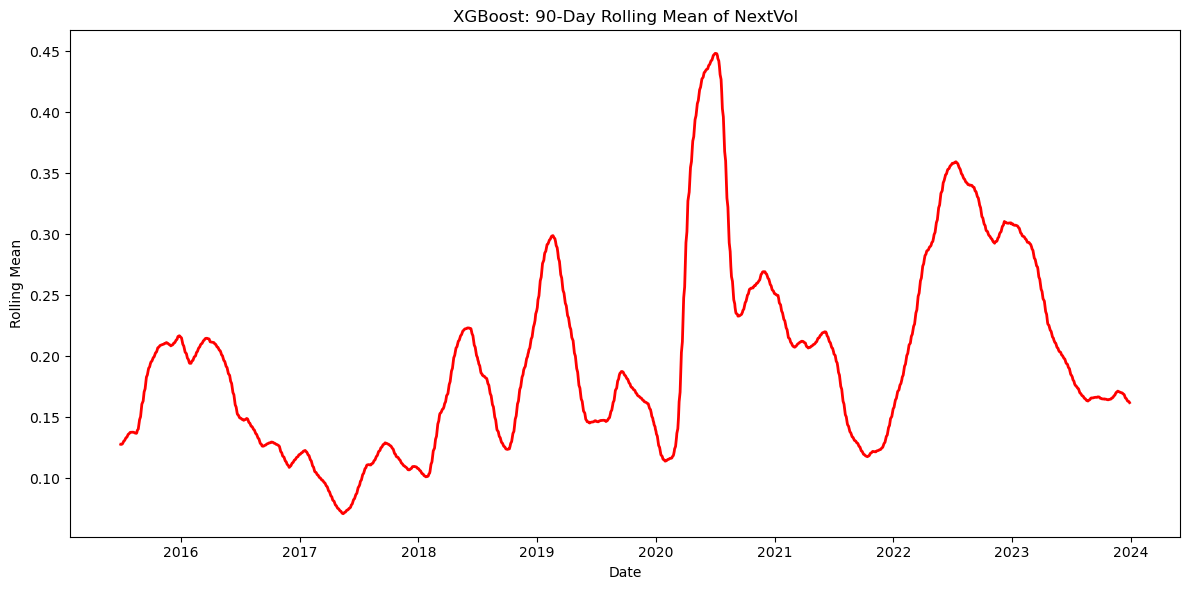

In [10]:
# 90-day Rolling Mean of Nextvol - line graph
mr_sorted = mr.sort_values("Date")
mr_sorted["Rolling90"] = mr_sorted["NextVol"].rolling(window=90).mean()
plt.figure(figsize=(12, 6))
plt.plot(mr_sorted.Date, mr_sorted.Rolling90, color="red", linewidth=2)
plt.title("XGBoost: 90-Day Rolling Mean of NextVol")
plt.xlabel("Date")
plt.ylabel("Rolling Mean")
plt.tight_layout()
plt.show()

In [11]:
# GARCH Analysis
adf_p = adfuller(df.QQQ_Return.dropna())[1]
arch_p = het_arch(df.QQQ_Return.dropna(), maxlag=10)[1]
print(f"ADF p-value={adf_p}, \nARCH LM p-value={arch_p}")

ADF p-value=3.7905113485541916e-29, 
ARCH LM p-value=2.429725489346757e-144


In [12]:
# Expanding-window GARCH
test_exp = df[df.Date >= "2020-01-01"].copy()
preds_exp = []
for d in test_exp.Date:
    hist = df[df.Date < d].QQQ_Return
    res = arch_model(hist, vol="Garch", p=1, q=1).fit(disp="off")
    var = res.forecast(horizon=1).variance.iloc[-1, 0]
    preds_exp.append(np.sqrt(var) * np.sqrt(252))
garch_exp = pd.Series(preds_exp, index=test_exp.Date, name="GARCH_Exp_Pred")
y_true_exp = test_exp.set_index("Date").QQQ_Realized_Volatility

mse_exp = mean_squared_error(y_true_exp, garch_exp)
rmse_exp = np.sqrt(mse_exp)
metrics_exp = {
    "MSE": mse_exp,
    "RMSE": rmse_exp,
    "R2": r2_score(y_true_exp, garch_exp),
    "MAE": mean_absolute_error(y_true_exp, garch_exp),
    "MAPE": mean_absolute_percentage_error(y_true_exp, garch_exp),
}
metrics_exp

{'MSE': 0.0020936352629148005,
 'RMSE': 0.0457562592758062,
 'R2': 0.8528370062662789,
 'MAE': 0.029438780157420685,
 'MAPE': 0.1325516880987805}

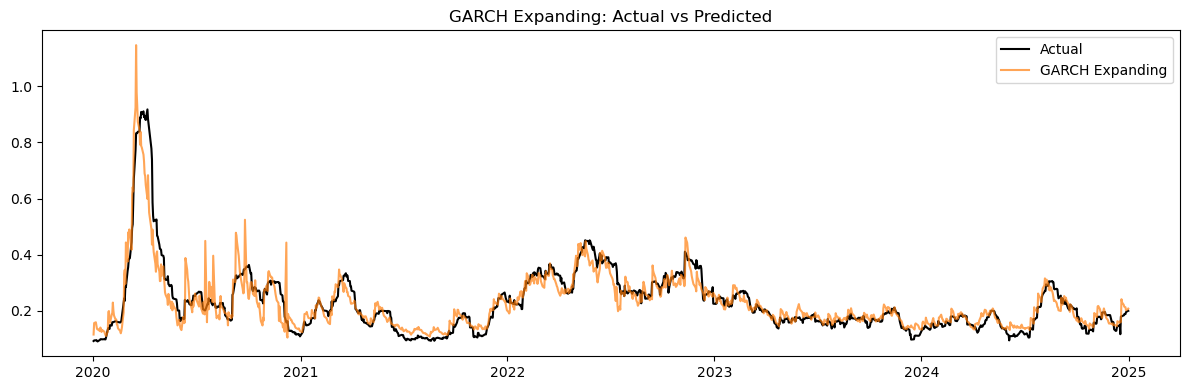

In [13]:
# GARCH expanding
plt.figure(figsize=(12, 4))
plt.plot(y_true_exp.index, y_true_exp, label="Actual", color="black")
plt.plot(garch_exp.index, garch_exp, label="GARCH Expanding", color="C1", alpha=0.7)
plt.title("GARCH Expanding: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Fixed-window GARCH
preds_fix, dates_fix = [], []
for d in test_exp.Date:
    ws = d - pd.DateOffset(years=3)
    hist = df[(df.Date >= ws) & (df.Date < d)].QQQ_Return
    if len(hist) < 200:
        preds_fix.append(np.nan)
    else:
        res = arch_model(hist, vol="Garch", p=1, q=1).fit(disp="off")
        var = res.forecast(horizon=1).variance.iloc[-1, 0]
        preds_fix.append(np.sqrt(var) * np.sqrt(252))
    dates_fix.append(d)
garch_fix = pd.Series(preds_fix, index=dates_fix, name="GARCH_Fix_Pred").dropna()
y_true_fix = y_true_exp.loc[garch_fix.index]

mse_fix = mean_squared_error(y_true_fix, garch_fix)
rmse_fix = np.sqrt(mse_fix)
metrics_fix = {
    "MSE": mse_fix,
    "RMSE": rmse_fix,
    "R2": r2_score(y_true_fix, garch_fix),
    "MAE": mean_absolute_error(y_true_fix, garch_fix),
    "MAPE": mean_absolute_percentage_error(y_true_fix, garch_fix),
}
metrics_fix

{'MSE': 0.0028448177029483813,
 'RMSE': 0.053336832517017554,
 'R2': 0.8000359006135022,
 'MAE': 0.03490711830739073,
 'MAPE': 0.15091903128314843}

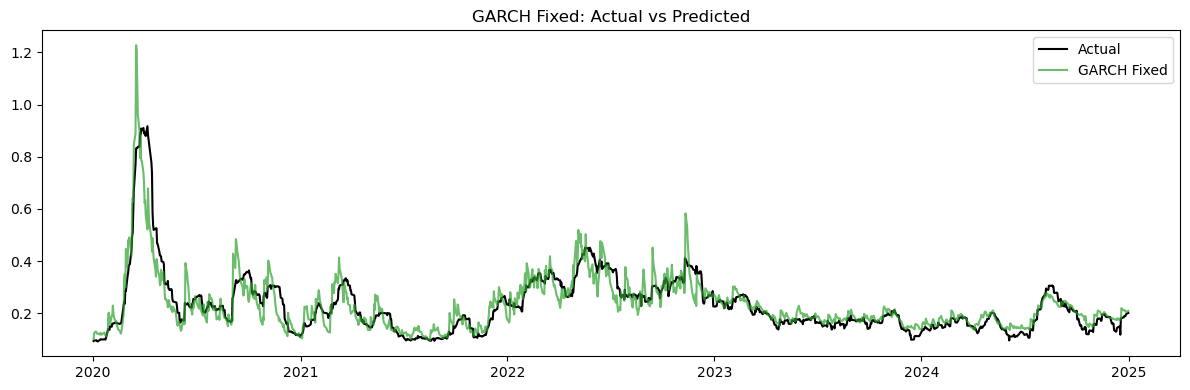

In [15]:
# Garch Fixed
plt.figure(figsize=(12, 4))
plt.plot(y_true_fix.index, y_true_fix, label="Actual", color="black")
plt.plot(garch_fix.index, garch_fix, label="GARCH Fixed", color="C2", alpha=0.7)
plt.title("GARCH Fixed: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# ——— 3. Comparative Analysis (including GARCH Expanding & Fixed) ———

# 1) Join XGBoost with both GARCH series
comp = (
    out_df.set_index("Date")[["ActualNextVol", "PredictedNextVol"]]
    .join(garch_exp.rename("GARCH_Exp_Pred"), how="inner")
    .join(garch_fix.rename("GARCH_Fix_Pred"), how="inner")
    .rename(columns={"PredictedNextVol": "XGB_Pred"})
)

In [23]:
# 2) Build metrics dict & DataFrame, rounded to 4 decimals
metrics_comp = {
    "XGBoost":        metrics_xgb,
    "GARCH_Expanding":metrics_exp,
    "GARCH_Fixed":    metrics_fix
}
metrics_df = pd.DataFrame(metrics_comp).T.round(4).reset_index().rename(columns={"index":"Model"})
print("Comparison Metrics:\n", metrics_df)

Comparison Metrics:
              Model     MSE    RMSE      R2     MAE    MAPE
0          XGBoost  0.0008  0.0279  0.9521  0.0146  0.0591
1  GARCH_Expanding  0.0021  0.0458  0.8528  0.0294  0.1326
2      GARCH_Fixed  0.0028  0.0533  0.8000  0.0349  0.1509


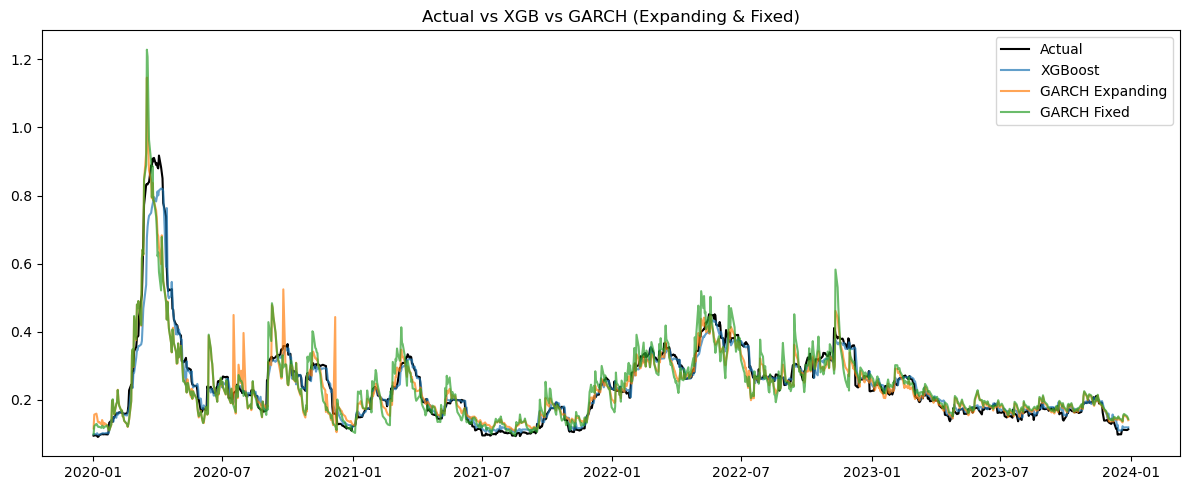

In [18]:
# 3) Line plot: Actual vs all forecasts
plt.figure(figsize=(12, 5))
plt.plot(comp.index, comp.ActualNextVol,     label="Actual",            color="black")
plt.plot(comp.index, comp.XGB_Pred,          label="XGBoost",           alpha=0.7)
plt.plot(comp.index, comp.GARCH_Exp_Pred,    label="GARCH Expanding",    alpha=0.7)
plt.plot(comp.index, comp.GARCH_Fix_Pred,    label="GARCH Fixed",        alpha=0.7)
plt.title("Actual vs XGB vs GARCH (Expanding & Fixed)")
plt.legend(); plt.tight_layout(); plt.show()

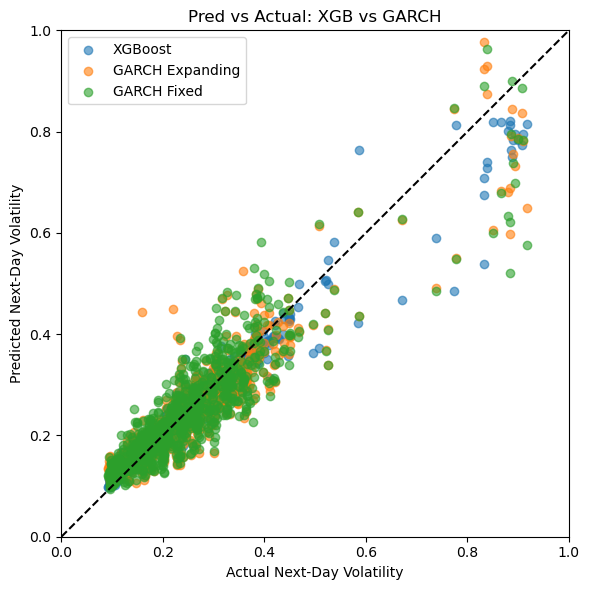

In [19]:
# 4) Scatter: Predicted vs Actual for each model
plt.figure(figsize=(6, 6))
plt.scatter(comp.ActualNextVol, comp.XGB_Pred,       label="XGBoost",        alpha=0.6)
plt.scatter(comp.ActualNextVol, comp.GARCH_Exp_Pred, label="GARCH Expanding", alpha=0.6)
plt.scatter(comp.ActualNextVol, comp.GARCH_Fix_Pred, label="GARCH Fixed",     alpha=0.6)
mx = comp[["ActualNextVol","XGB_Pred","GARCH_Exp_Pred","GARCH_Fix_Pred"]].max().max()
plt.plot([0, mx], [0, mx], "k--")
ax = plt.gca()
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
plt.xlabel("Actual Next-Day Volatility"); plt.ylabel("Predicted Next-Day Volatility")
plt.title("Pred vs Actual: XGB vs GARCH"); plt.legend(); plt.tight_layout(); plt.show()

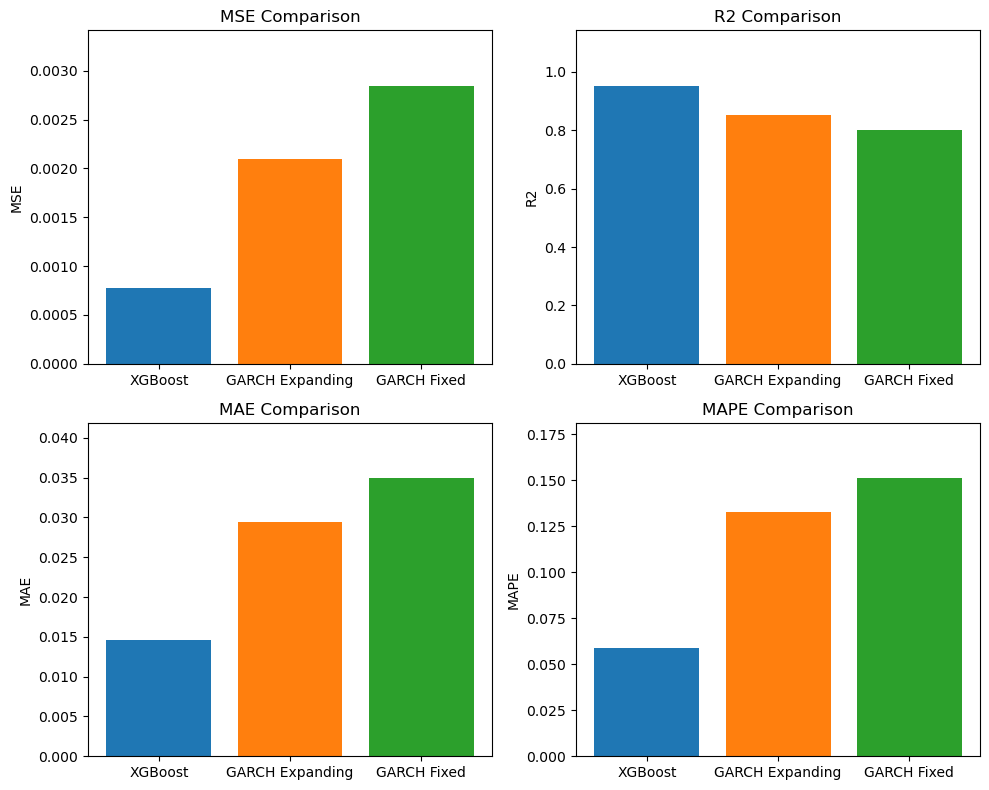

In [20]:
# 5) Subplots: MSE, R2, MAE, MAPE comparison
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for ax, metric in zip(axes, ["MSE", "R2", "MAE", "MAPE"]):
    ax.bar(
        ["XGBoost", "GARCH Expanding", "GARCH Fixed"],
        [metrics_comp[m][metric] for m in ("XGBoost","GARCH_Expanding","GARCH_Fixed")],
        color=["C0","C1","C2"]
    )
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.set_ylim(0, max(metrics_comp["GARCH_Fixed"][metric], metrics_comp["XGBoost"][metric]) * 1.2)
plt.tight_layout(); plt.show()

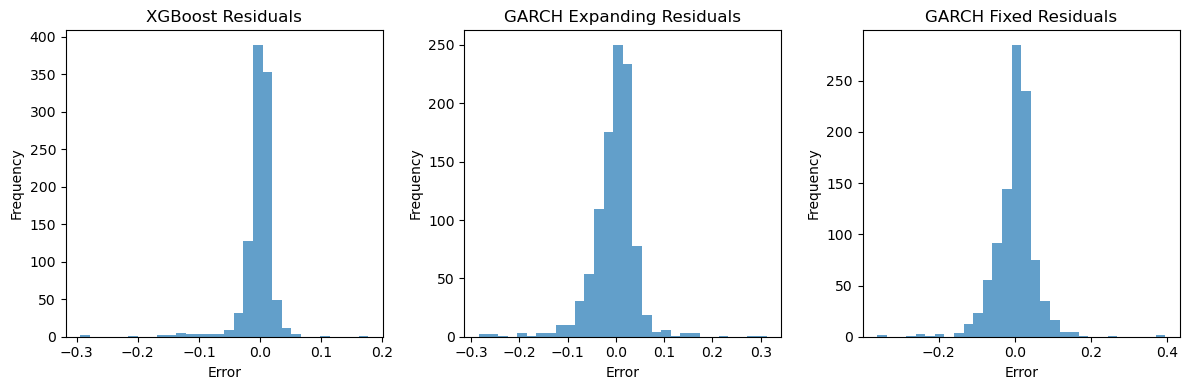

In [21]:
# 6) Residual histograms side-by-side
plt.figure(figsize=(12, 4))
for i,(label,col) in enumerate([
    ("XGBoost",       "XGB_Pred"),
    ("GARCH Expanding","GARCH_Exp_Pred"),
    ("GARCH Fixed",   "GARCH_Fix_Pred"),
]):
    plt.subplot(1,3,i+1)
    plt.hist(comp[col] - comp.ActualNextVol, bins=30, alpha=0.7)
    plt.title(f"{label} Residuals")
    plt.xlabel("Error"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()